# Régression logistique

## 1 Régularisation de de Tikhonov

### 1.1 Fonction, gradient et hessienne.

$
f_1: (w_0, w) \mapsto \frac{1}{n}\sum_{i=1}^nlog(1 + e^{-y_i(x_i^Tw + w_0)}) + \frac{\rho}{2}\|w\|_2^2
$

#### Gradient de $f_1$

$\frac{\partial f_1}{\partial w_0}(w_0, w) = \frac{1}{n}\sum_{i=1}^n\frac{-y_ie^{-y_i(x_i^Tw+w_0)}}{1 + e^{-y_i(x_i^T+w_0)}} = \frac{1}{n}\sum_{i=1}^n\frac{-y_i}{1 + e^{y_i(x_i^T+w_0)}}$

$\frac{\partial f_1}{\partial w}(w_0, w) = \frac{1}{n}\sum_{i=1}^n\frac{-y_ie^{-y_i(x_i^Tw+w_0)}}{1 + e^{-y_i(x_i^T+w_0)}}x_i + \rho w = \frac{1}{n}\sum_{i=1}^n\frac{-y_i}{1 + e^{y_i(x_i^T+w_0)}}x_i + \rho w$

$\nabla f_1(w_0, w) = \begin{pmatrix}\frac{1}{n}\sum_{i=1}^n\frac{-y_i}{1 + e^{y_i(x_i^T+w_0)}} \\ \frac{1}{n}\sum_{i=1}^n\frac{-y_i}{1 + e^{y_i(x_i^T+w_0)}}x_i + \rho w\end{pmatrix}$

#### Matrice hessienne de $f_1$

$\frac{\partial^2f_1}{\partial w_0^2}(w_0, w) = \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}$

$\frac{\partial^2f_1}{\partial w^2}(w_0, w) = \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_ix_i^T + \rho I_p$

$\frac{\partial^2{f_1}}{\partial w_0\partial w}(w_0, w) = \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_i^T$

$\frac{\partial^2{f_1}}{\partial w\partial w_0}(w_0, w) = \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_i$

$\text{Soit H la matrice hessienne de $f_1$ : }H(f_1) = \begin{bmatrix}\frac{\partial^2f_1}{\partial w_0^2} & \frac{\partial^2{f_1}}{\partial w_0\partial w} \\ \frac{\partial^2{f_1}}{\partial w\partial w_0} & \frac{\partial^2f_1}{\partial w^2}\end{bmatrix} = \begin{bmatrix}\frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2} & \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_i^T \\ \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_i & \frac{1}{n}\sum_{i=1}^ny_i^2\frac{e^{y_i(x_i^Tw+w_0)}}{(1 + e^{y_i(x_i^T+w_0)})^2}x_ix_i^T + \rho  I_p\end{bmatrix}$

#### Convexité de $f_1$

$\|.\|_2^2$ est convexe.  
Soit $f: x \mapsto log(1 + e^x)$ ; $\frac{\partial^2{f}}{\partial x^2}(x) = \frac{e^x}{(1 + e^x)^2} > 0$ donc $f$ est convexe. De plus, $(w_0, w) \mapsto x_i^Tw + w_0$ est une fonction affine donc convexe.

Ainsi, $f_1$ est convexe.

### 1.2 Implémentation

In [1]:
import numpy as np
from numpy.linalg import norm
from numpy.linalg import inv
from scipy.optimize import check_grad
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

In [3]:
def f1(W, X, y):
    """
    Return the value of the function, the gradient, and the Hessian.
    Input:
    W: (w0, w) parameter for the regression
    X: data input
    y: data output
    Output:
    val: value of f1
    grad: gradient
    hes: Hessian
    """

    n, p = X.shape
    rho = 1/n
    # Vectorization convenience.
    X1 = np.column_stack([np.ones(n), X])
    # Compute only once.
    e = np.exp(y*(W.dot(X1.T)))
    r = e / ((1 + e)**2)

    val = np.log(1 + np.exp(-y*(W.dot(X1.T)))).sum()/n + rho*norm(W[1:])**2/2
    grad = np.concatenate((
        [-y.dot(1/(1+e))/n],
        (-y/(1+e)).dot(X)/n + rho*W[1:]))
    hes = np.column_stack([
        np.concatenate(([(y**2).dot(r)/n], ((y**2)*r).dot(X)/n)),
        np.row_stack([((y**2)*r).dot(X)/n,
            ((y**2)*r*X.T).dot(X)/n + rho*np.eye(p)])])

    return val, grad, hes

Test du calcul du gradient :

In [4]:
X, y = load_diabetic_retinopathy('diabeticRetinopathy.csv')
n, p = X.shape
W = np.ones(p+1)
print(check_grad(lambda W: f1(W, X, y)[0], lambda W: f1(W, X, y)[1], W))

8.10381131131e-08


L'erreur étant très proche de 0, le résultat est satisfaisant.

### 1.3 Méthode de Newton

In [5]:
def newton(f, W0, thresh):
    """
    Optimize f by the Newton's method.
    Input:
    f: function to be optimized
    W0: initial condition
    thresh: threshold for the optimization
    Output:
    W: minimiser
    """

    W = W0
    grad = f(W)[1]
    ng = norm(grad)
    wl = [ng]
    while ng >= thresh:
        W = W - grad.dot(inv(f(W)[2]))
        grad = f(W)[1]
        ng = norm(grad)
        wl.append(ng)

    sns.set()
    plt.plot(wl)
    plt.show()

    return W

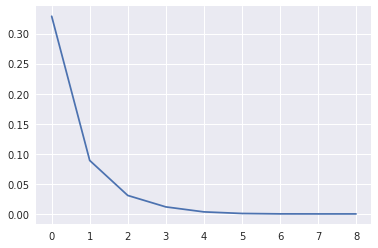

array([ 0.67731198,  0.28526576, -0.24554742,  5.61365006,  0.9888679 ,
       -1.82791918, -2.55695256, -1.58747255,  0.43396361,  0.48515529,
       -0.40441764,  0.17280405, -0.57564945,  0.43832626, -0.62435831,
        1.25356177,  0.72621094, -0.00607139, -0.1490878 , -0.09505212])

In [6]:
newton(lambda W: f1(W, X, y), np.zeros(p+1), 10**-10)

### 1.4 Méthode de Newton appliquée avec 0.3e

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


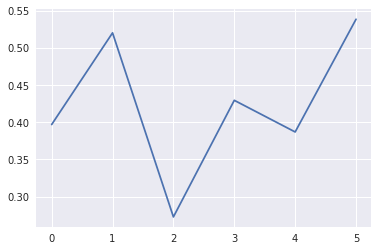

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [7]:
newton(lambda W: f1(W, X, y), 0.3*np.ones(p+1), 10**-10)

On observe que si la méthode de Newton converge lorsqu'elle est initialisée avec (0, 0) elle diverge pour 0.3e.

### 1.5 Recherche linéaire d'Armijo

In [ ]:
def armijo(f, W0, thresh, a, b, beta):
    """
    Armijo's line search
    Input:
    f: function to be optimized
    W0: initial condition
    thresh: threshold for the optimization
    a, b, beta: parameter for Armijo's search
    Output:
    W: minimiser
    """

    W = W0
    grad = f(W)[1]
    ng = norm(grad)
    wl = [ng]
    while ng >= thresh:
        l = 0
        while f(W-b*(a**l)*grad)[0] <= f(W)[0] + beta*grad.dot(-b*(a**l)*grad):
            l = l+1
        W = W - b*(a**l)*grad
        b = 2*b*(a**l)
        grad = f(W)[1]
        ng = norm(grad)
        wl.append(ng)

    sns.set()
    plt.plot(wl)
    plt.show()

    return W

In [ ]:
armijo(lambda W: f1(W, X, y), np.ones(p+1), 10**-10, 1/2, 1/2, 10**(-4))

## 2 Régularisation pour la parcimonie

$\min_{w_0\in\mathbb{R}, w\in\mathbb{R}^p}\frac{1}{n}\sum_{i=1}^nlog(1 + e^{-y_i(x_i^Tw + w_0)}) + \frac{\rho}{2}\|w\|_1$

### 2.1 Méthode de Newton ?

La norme 1 n'étant pas $\mathit{C}^2$ on ne peut pas utiliser la méthode de Newton.

### 2.2 Décomposition de la fonction objectif

$
F_2 = f_2 + g_2 \\
f_2 : (w_0, w) \mapsto \frac{1}{n}\sum_{i=1}^nlog(1 + e^{-y_i(x_i^Tw + w_0)}) \\
g_2 : (w_0, w) \mapsto \frac{\rho}{2}\|w\|_1 \\
prox_{g_2} : (w_0, w) \mapsto (S_\rho(w_0), S_\rho(w_1), ..., S_\rho(w_p))
$

where $S_\rho$ is the soft threshold, i.e. :

$$
S_\rho : x \mapsto \begin{cases}
    x-\rho & \text{if } x>\rho \\
    x+\rho & \text{if } x<\rho \\
    0 & \text{if } x \in [-\rho, \rho]\end{cases}
$$